In [120]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [121]:
data=pd.read_csv('sales.csv')
data.head()

,Date,Amount
0,1/1/2000,510
1,2/1/2000,515
2,3/1/2000,530
3,4/1/2000,527
4,5/1/2000,519


In [122]:
data.tail()

,Date,Amount
103,8/1/2008,766
104,9/1/2008,703
105,10/1/2008,644
106,11/1/2008,604
107,12/1/2008,630


In [123]:
data['Date']=pd.to_datetime(data['Date'])       # Pre-processing

In [124]:
data.tail()

,Date,Amount
103,2008-08-01,766
104,2008-09-01,703
105,2008-10-01,644
106,2008-11-01,604
107,2008-12-01,630


In [125]:
data.set_index('Date',inplace=True)         # Changing Index from continuous numbers to date wise.
data.head()

,Amount
Date,
2000-01-01,510
2000-02-01,515
2000-03-01,530
2000-04-01,527
2000-05-01,519


<Axes: xlabel='Date'>

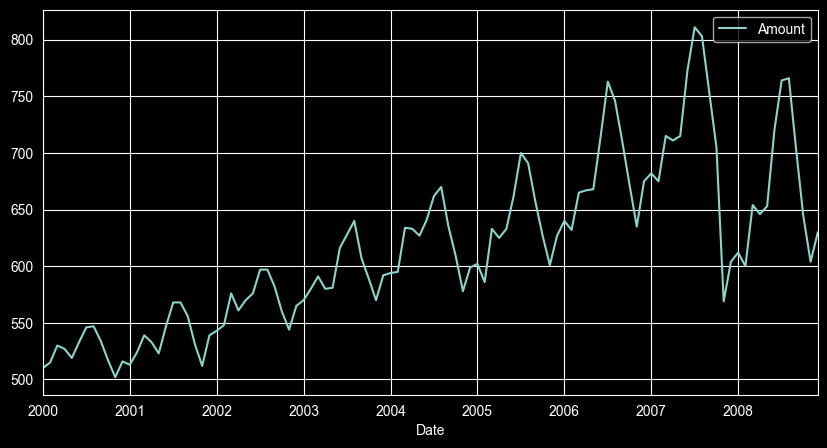

In [126]:
data.plot(figsize=(10,5))

In [127]:
from statsmodels.tsa.stattools import adfuller

In [128]:
# Before choosing p and q, the time series must be stationary. ARIMA does not work properly on non-stationary data.
### Stationary means:
# Mean is constant
# Variance is constant
# No trend over time

In [129]:
def adf_test(d):
    result=adfuller(d)
    print('P value ->',result[1])
    if result[1] <= 0.05:
        print("Reject the H₀. Data is stationary")
    else:
        print("Accept (Failed to reject) the H₀, Data is not stationary ")

In [130]:
adf_test(data['Amount'])

P value -> 0.5644352099925031
Accept (Failed to reject) the H₀, Data is not stationary 


In [131]:
data['First Difference']=data['Amount']-data['Amount'].shift(1)

In [132]:
data.head()

,Amount,First Difference
Date,,
2000-01-01,510,NaN
2000-02-01,515,5.0
2000-03-01,530,15.0
2000-04-01,527,-3.0
2000-05-01,519,-8.0


In [133]:
adf_test(data['First Difference'].dropna())         # Dropped NAN values because: MissingDataError: exog contains inf or nans

P value -> 0.07478507605167106
Accept (Failed to reject) the H₀, Data is not stationary 


In [134]:
data['Second Difference']=data['First Difference']-data['First Difference'].shift(1)

In [135]:
data.head()

,Amount,First Difference,Second Difference
Date,,,
2000-01-01,510,NaN,NaN
2000-02-01,515,5.0,NaN
2000-03-01,530,15.0,10.0
2000-04-01,527,-3.0,-18.0
2000-05-01,519,-8.0,-5.0


In [136]:
adf_test(data['Second Difference'].dropna())            # d = 2


P value -> 3.4877399176947936e-15
Reject the H₀. Data is stationary


In [137]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [138]:
# ACF (Autocorrelation Function) tells you q (MA part – Moving Average)
# Because ACF shows the overall correlation, including error effects.
# q = how many past errors (shocks/noise) influence today
# If today is affected by yesterday’s error → q = 1
# If affected by errors from the last 2 days → q = 2

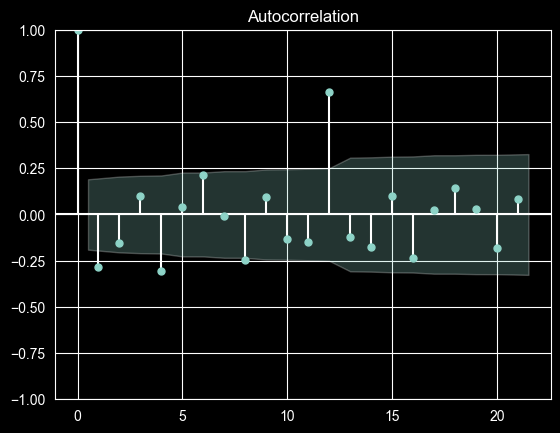

In [139]:
plot1 = plot_acf(data["Second Difference"].dropna())            # q = count of past errors = 3

In [140]:
# PACF (Partial Autocorrelation Function) tells you p (AR part – AutoRegression)
# Because PACF shows the direct influence of each lag.
# p = how many past values directly influence today
# If today depends on yesterday only → p = 1
# If today depends on yesterday + day before yesterday → p = 2

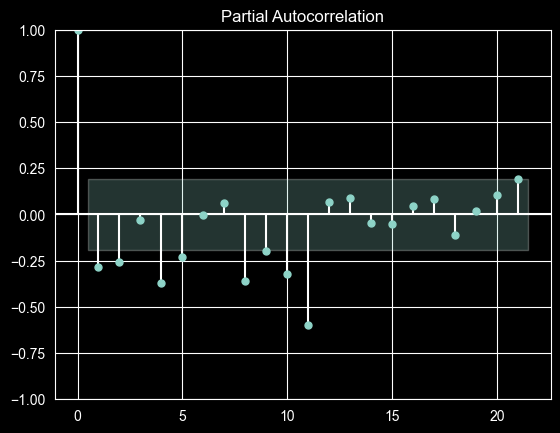

In [141]:
plot2 = plot_pacf(data["Second Difference"].dropna())       # p = influence points = 7

In [142]:
data['Seasonal Difference']=data['Amount']-data['Amount'].shift(12)         # d = seasonal factor = 12
data

,Amount,First Difference,Second Difference,Seasonal Difference
Date,,,,
2000-01-01,510,NaN,NaN,NaN
2000-02-01,515,5.0,NaN,NaN
2000-03-01,530,15.0,10.0,NaN
2000-04-01,527,-3.0,-18.0,NaN
2000-05-01,519,-8.0,-5.0,NaN
...,...,...,...,...
2008-08-01,766,2.0,-42.0,-37.0
2008-09-01,703,-63.0,-65.0,-51.0
2008-10-01,644,-59.0,4.0,-61.0


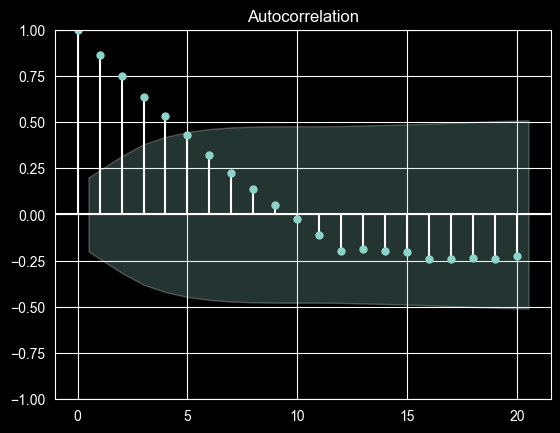

In [143]:
plot3 = plot_acf(data["Seasonal Difference"].dropna())              # q = error = 4 (seasonal)

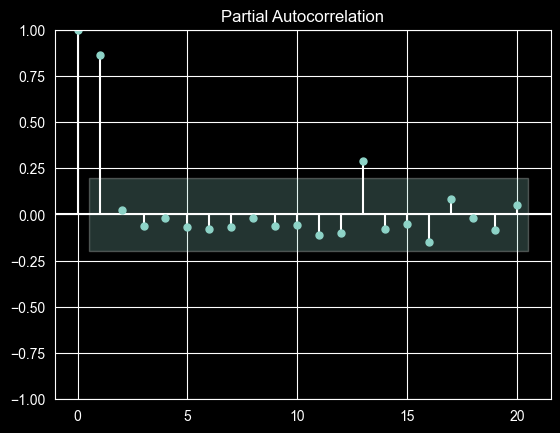

In [144]:
plot4 = plot_pacf(data["Seasonal Difference"].dropna())             # p = influence factor = 2 (seasonal)

In [145]:
from datetime import datetime

In [146]:
train_data=data

In [147]:
train_data

,Amount,First Difference,Second Difference,Seasonal Difference
Date,,,,
2000-01-01,510,NaN,NaN,NaN
2000-02-01,515,5.0,NaN,NaN
2000-03-01,530,15.0,10.0,NaN
2000-04-01,527,-3.0,-18.0,NaN
2000-05-01,519,-8.0,-5.0,NaN
...,...,...,...,...
2008-08-01,766,2.0,-42.0,-37.0
2008-09-01,703,-63.0,-65.0,-51.0
2008-10-01,644,-59.0,4.0,-61.0


In [148]:
from statsmodels.tsa.arima.model import ARIMA
modela=ARIMA(train_data['Amount'],order=(7,2,3))            # p, d, q
arima_modal = modela.fit()

In [149]:
predicteda = arima_modal.predict(start=datetime(2003,1,1),end=datetime(2008,12,1))

In [150]:
train_data['Predicted_arima']=predicteda
train_data

,Amount,First Difference,Second Difference,Seasonal Difference,Predicted_arima
Date,,,,,
2000-01-01,510,NaN,NaN,NaN,NaN
2000-02-01,515,5.0,NaN,NaN,NaN
2000-03-01,530,15.0,10.0,NaN,NaN
2000-04-01,527,-3.0,-18.0,NaN,NaN
2000-05-01,519,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
2008-08-01,766,2.0,-42.0,-37.0,754.999880
2008-09-01,703,-63.0,-65.0,-51.0,770.062670
2008-10-01,644,-59.0,4.0,-61.0,678.001663


<Axes: xlabel='Date'>

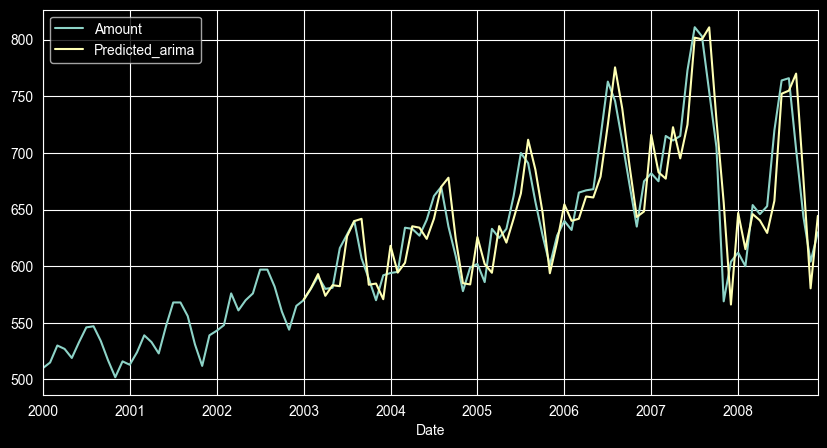

In [151]:
train_data[['Amount','Predicted_arima']].plot(figsize=(10,5))

In [152]:
from statsmodels.tsa.statespace.sarimax import SARIMAX      # Seasonal Arima

In [153]:
smodel=SARIMAX(train_data['Amount'],order=(2,0,4),seasonal_order=(0,1,0,12))            # normal difference(p, d(considered?), q), seasonal difference(p(considered?), d(considered?), q(considered?), d) ; 0 => not considered, 1 => considered

In [154]:
sarimax_model=smodel.fit()

In [155]:
predicted = sarimax_model.predict(start=datetime(2003, 1, 1), end=datetime(2008, 12, 1))

In [156]:
train_data['Predicted']=predicted
train_data

,Amount,First Difference,Second Difference,Seasonal Difference,Predicted_arima,Predicted
Date,,,,,,
2000-01-01,510,NaN,NaN,NaN,NaN,NaN
2000-02-01,515,5.0,NaN,NaN,NaN,NaN
2000-03-01,530,15.0,10.0,NaN,NaN,NaN
2000-04-01,527,-3.0,-18.0,NaN,NaN,NaN
2000-05-01,519,-8.0,-5.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2008-08-01,766,2.0,-42.0,-37.0,754.999880,763.089110
2008-09-01,703,-63.0,-65.0,-51.0,770.062670,722.759832
2008-10-01,644,-59.0,4.0,-61.0,678.001663,664.085794


<Axes: xlabel='Date'>

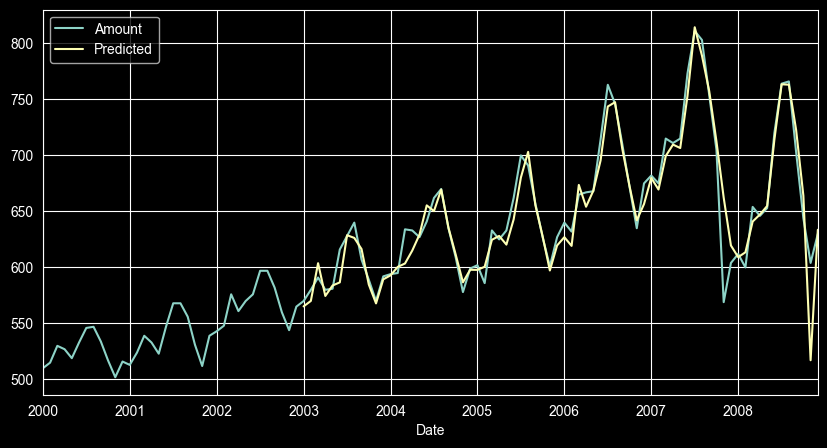

In [157]:
train_data[['Amount','Predicted']].plot(figsize=(10,5))

<Axes: xlabel='Date'>

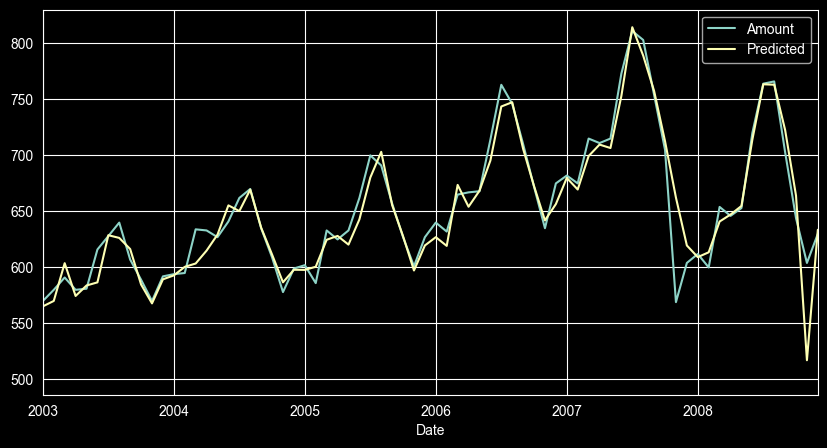

In [158]:
train_data[['Amount','Predicted']].plot(xlim=['2003-01-01','2008-12-01'],figsize=(10,5))

2009-01-01    646.927679
2009-02-01    626.915555
2009-03-01    685.770011
2009-04-01    679.601766
2009-05-01    686.549355
2009-06-01    752.073181
2009-07-01    793.582657
2009-08-01    792.431073
2009-09-01    725.914120
2009-10-01    663.271228
2009-11-01    619.689002
2009-12-01    642.306074
Freq: MS, Name: predicted_mean, dtype: float64

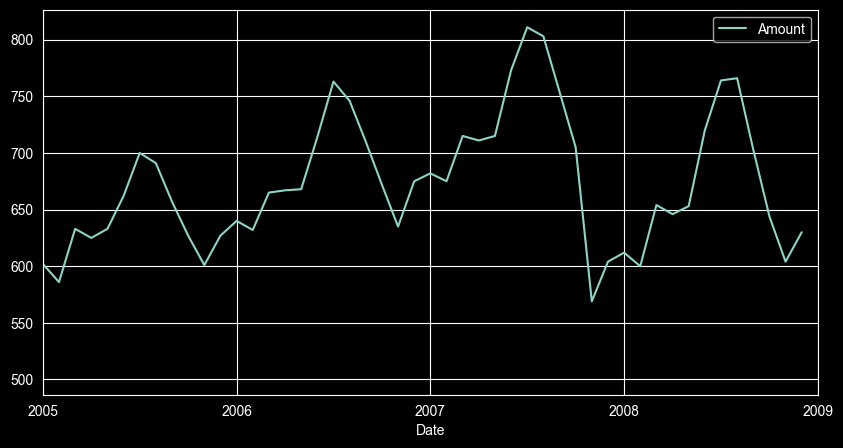

In [159]:
predicted1 = sarimax_model.predict(start=datetime(2009, 1, 1), end=datetime(2009, 12, 1))
train_data['Predicted1']=predicted1
train_data[['Amount']].plot(xlim=['2005-01-01','2009-01-01'],figsize=(10,5))
predicted1

<Axes: >

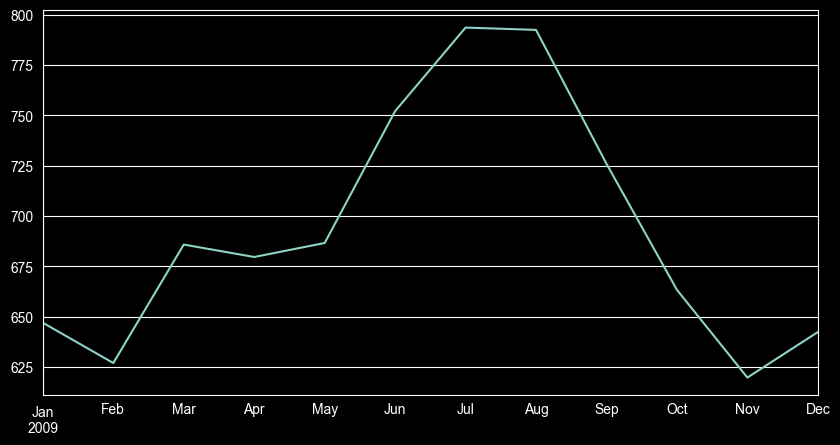

In [160]:
predicted1.plot(figsize=(10,5))

In [162]:
import pickle

with open('models/sarimax_model.pkl','wb') as f:
    pickle.dump(sarimax_model,f)